In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
from scipy.stats import shapiro, ttest_rel, friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.gridspec import GridSpec

plt.rcParams['svg.fonttype'] = 'none'


### PATH

#path = ''

deepCeres = path + "deepCeres/"

acapulco = path + "acapulco/"
#acapulco_source = "HNU/derivatives/acapulco/"

suit = path + "vbm_suit/"

ceres = path + "ceres/"


### DATA AND PALETTE

csv_files = {
    "SUIT": path + '/icc/suit_all_lobules_ICC.csv',
    "CERES": path + '/icc/ceres_all_lobules_ICC.csv',
    "ACAPULCO": path + '/icc/acapulco_all_lobules_ICC.csv',
    "DeepCERES": path + '/icc/deepCeres_all_lobules_ICC.csv'
}

dataframes = []
for method, file in csv_files.items():
    df = pd.read_csv(file, index_col=0)
    df["Lobule"] = df.index
    df["Method"] = method
    dataframes.append(df)

df_all = pd.concat(dataframes, ignore_index=True)
df_all = df_all[["Method", "Lobule", "ICC.a", "sigma2_b", "sigma2_w"]].rename(columns={"ICC.a" : "ICC", "sigma2_b": "Between Variation", "sigma2_w": "Within Variation"})

colors = ["#1b9e77", "#ffd92f", "#7570b3", "#e78ac3"]
methods = ["DeepCERES", "CERES", "ACAPULCO", "SUIT"]
pairs = list(combinations(methods, 2))
palette = dict(zip(methods, colors))

metrics = ["ICC", "Between Variation", "Within Variation"]


# Star annotation function
def get_star(p):
    return (
        "****" if p < 0.0001 else
        "***"  if p < 0.001 else
        "**"   if p < 0.01 else
        "*"    if p < 0.05 else
        "n.s."
    )

# Statistics
## Demographic data

In [2]:
# Get subjects list and information
subjects = pd.read_csv(path+'subjects.csv')
subjects_list = subjects['ID'].tolist()

print(subjects_list)
subjects

['sub-0025434', 'sub-0025435', 'sub-0025440', 'sub-0025444', 'sub-0025446', 'sub-0025447', 'sub-0025449', 'sub-0025454', 'sub-0025455']


,ID,age,sex
0,sub-0025434,24,M
1,sub-0025435,30,F
2,sub-0025440,24,M
3,sub-0025444,27,F
4,sub-0025446,30,M
5,sub-0025447,26,M
6,sub-0025449,22,M
7,sub-0025454,26,M
8,sub-0025455,25,M


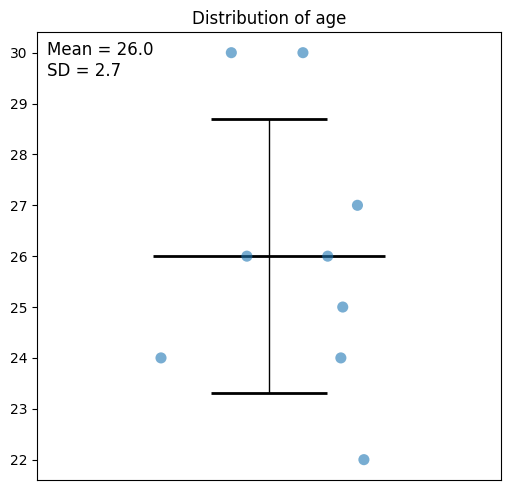

In [3]:
age_control = subjects['age']
age_mean = age_control.mean()
age_std = age_control.std(ddof=1)

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)

# Scatterplot
sns.stripplot(
    data=pd.DataFrame(age_control),
    size=8,
    jitter=0.1,
    alpha=0.6,
    ax=ax
)

# Mean ± SD lines
ax.hlines(age_mean, -0.1, 0.1, colors='k', linewidth=2)
ax.hlines(
    [age_mean - age_std, age_mean + age_std],
    -0.05, 0.05,
    colors='k', linewidth=2
)
ax.vlines(0, age_mean - age_std, age_mean + age_std, colors='k', linewidth=1)

# Axis formatting
ax.set_xlim(-0.2, 0.2)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_title('Distribution of age')

# Text annotation
ax.text(
    0.02, 0.98,
    f'Mean = {age_mean:.1f}\nSD = {age_std:.1f}',
    transform=ax.transAxes,
    ha='left',
    va='top',
    fontsize=12
)

plt.tight_layout()
plt.show()

## Normality tests

In [4]:
# Shapiro-Wilk normality test
print("Shapiro-Wilk normality tests:")

for m in metrics:
    print(m)
    for method in methods:
        values = df_all[df_all["Method"] == method][m]
        stat, p = shapiro(values)
        print(f"  {method}: W = {stat:.4f}, p = {p:.4f}")

Shapiro-Wilk normality tests:
ICC
  DeepCERES: W = 0.6420, p = 0.0000
  CERES: W = 0.7919, p = 0.0012
  ACAPULCO: W = 0.9171, p = 0.1146
  SUIT: W = 0.5581, p = 0.0000
Between Variation
  DeepCERES: W = 0.9644, p = 0.6891
  CERES: W = 0.9459, p = 0.3648
  ACAPULCO: W = 0.8999, p = 0.0572
  SUIT: W = 0.9125, p = 0.0951
Within Variation
  DeepCERES: W = 0.7200, p = 0.0001
  CERES: W = 0.8037, p = 0.0017
  ACAPULCO: W = 0.9523, p = 0.4630
  SUIT: W = 0.7331, p = 0.0002


## Group tests

In [5]:
# NON PARAMETRIC TESTS

for m in metrics:
    if m == "Between Variation":
        continue
    
    print(m)

    df_new = df_all.pivot(
        index="Lobule",
        columns="Method",
        values=m
    )

    # Friedman Test
    print("  Friedman Test :")
    stat, p = friedmanchisquare(*[df_new[m] for m in methods])
    print(f"  χ² = {stat:.4f}, p = {p:.4f}")

    # Posthoc Nemenyi
    print("  Posthoc Nemenyi :")
    res = posthoc_nemenyi_friedman(df_all, group_col='Method', y_col=m, block_col='Lobule', block_id_col='Lobule', melted=True)

    # Print results
    for i, (m1, m2) in enumerate(pairs):
        p_val = res.loc[m1, m2]
        stars = get_star(p_val)
        print(f"  {m1} vs {m2}: p = {p_val:.4f} → {stars}")



# PARAMETRIC TEST

print("Between Variation")

df_new = df_all.pivot(
        index="Lobule",
        columns="Method",
        values="Between Variation"
    )

# Repeated Measures ANOVA
print("  Repeated Measures ANOVA :")
model = ols('Between_Variation ~ C(Method) + C(Lobule)', data=df_all.rename(columns={"Between Variation": "Between_Variation"})).fit()
anova_results = anova_lm(model, typ=2)
print(anova_results)

# Paired t-tests
print("  Post hoc pairwise paired t-tests :")
p_values = []

for m1, m2 in pairs:
    stat, p = ttest_rel(df_new[m1], df_new[m2])
    p_values.append(p)

# Correct p-values
_, corrected_p, _, _ = multipletests(p_values, method='fdr_bh')

# Print Results
for (m1, m2), p_raw, p_corr in zip(pairs, p_values, corrected_p):
    stars = get_star(p_corr)
    print(f"  {m1} vs {m2}: uncorrected p = {p_raw:.4f}, corrected p = {p_corr:.4f} → {stars}")


ICC
  Friedman Test :
  χ² = 9.2667, p = 0.0259
  Posthoc Nemenyi :
  DeepCERES vs CERES: p = 0.9172 → n.s.
  DeepCERES vs ACAPULCO: p = 0.0234 → *
  DeepCERES vs SUIT: p = 0.3352 → n.s.
  CERES vs ACAPULCO: p = 0.1247 → n.s.
  CERES vs SUIT: p = 0.7302 → n.s.
  ACAPULCO vs SUIT: p = 0.6510 → n.s.
Within Variation
  Friedman Test :
  χ² = 9.6000, p = 0.0223
  Posthoc Nemenyi :
  DeepCERES vs CERES: p = 1.0000 → n.s.
  DeepCERES vs ACAPULCO: p = 0.0483 → *
  DeepCERES vs SUIT: p = 0.4080 → n.s.
  CERES vs ACAPULCO: p = 0.0483 → *
  CERES vs SUIT: p = 0.4080 → n.s.
  ACAPULCO vs SUIT: p = 0.7302 → n.s.
Between Variation
  Repeated Measures ANOVA :
             sum_sq    df         F    PR(>F)
C(Method)  0.004244   3.0  4.406155  0.007857
C(Lobule)  0.021474  17.0  3.933888  0.000074
Residual   0.016376  51.0       NaN       NaN
  Post hoc pairwise paired t-tests :
  DeepCERES vs CERES: uncorrected p = 0.3562, corrected p = 0.4274 → n.s.
  DeepCERES vs ACAPULCO: uncorrected p = 0.0016, co

## Means

In [6]:
for m in metrics:
    print(df_all[['Method', m]].groupby('Method').mean())
    print('\n')

                ICC
Method             
ACAPULCO   0.820134
CERES      0.870184
DeepCERES  0.894938
SUIT       0.869150


           Between Variation
Method                      
ACAPULCO            0.047485
CERES               0.061663
DeepCERES           0.068657
SUIT                0.061289


           Within Variation
Method                     
ACAPULCO           0.008206
CERES              0.006704
DeepCERES          0.005282
SUIT               0.007279




# Figure 2 - Rex plot

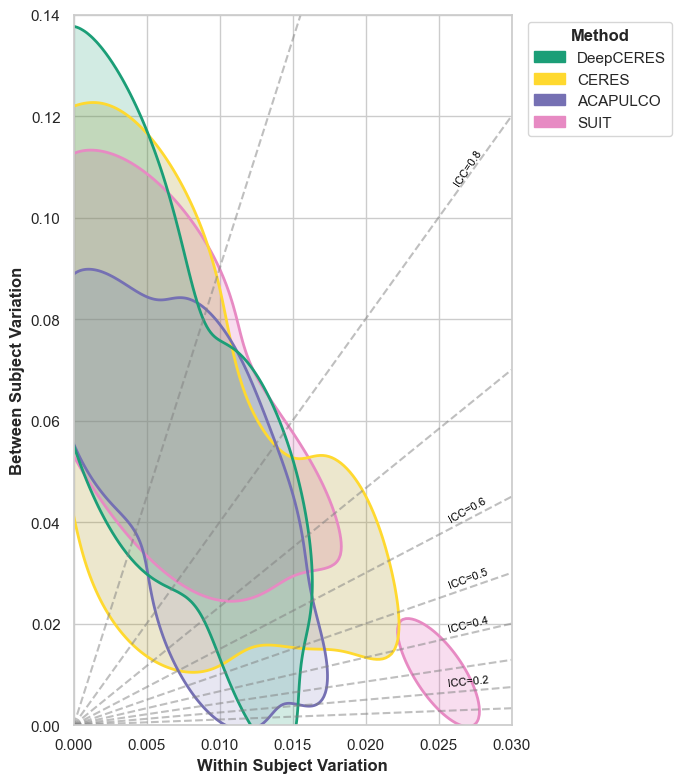

In [7]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(7, 8))

# Distribuion (kernel density estimate)
## Interior
sns.kdeplot(
    data=df_all,
    x="Within Variation",
    y="Between Variation",
    hue="Method",
    palette=palette,
    fill=True,
    alpha=0.2,
    ax=ax,
    levels=2,
    thresh=0.1
)
## Exterior
sns.kdeplot(
    data=df_all,
    x="Within Variation",
    y="Between Variation",
    hue="Method",
    palette=palette,
    fill=False,
    ax=ax,
    levels=1,
    thresh=0.1,
    linewidths=2
)


# ICC lines
icc_vals_lines = np.linspace(0.1, 0.9, 9)
icc_vals_labels = [0.2, 0.4, 0.5, 0.6, 0.8]
x_vals = np.linspace(0.0, 0.03, 500)

for icc in icc_vals_lines:
    y_vals = icc * x_vals / (1 - icc)
    ax.plot(x_vals, y_vals, ls="--", color="gray", alpha=0.5)

    if icc in icc_vals_labels:
        # Get the last two points to compute the slope
        x1, x2 = x_vals[0], x_vals[-1] + 0.05
        y1, y2 = y_vals[0], y_vals[-1] 

        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))

        # Coordinates for the text
        x_label = x_vals[-1] * 0.9
        y_label = y_vals[-1] * 0.9

        ax.text(
            x_label,
            y_label + 0.002,
            f"ICC={icc}",
            fontsize=8,
            color="black",
            rotation=angle,
            rotation_mode='anchor',
            horizontalalignment='center',
            verticalalignment='center'
        )


# Axes labels and limits
ax.set_xlim(0, 0.03)
ax.set_ylim(0, 0.14)
ax.set_xlabel("Within Subject Variation", weight="bold")
ax.set_ylabel("Between Subject Variation", weight="bold")

# Legend
handles = [Patch(color=palette[method], label=methods[i]) for i ,method in enumerate(methods)]
ax.legend(
    handles=handles,
    title="Method",
    title_fontproperties={'weight': 'bold'},
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)

# Display
plt.tight_layout()
#plt.savefig("rex_icc.svg", format="svg", bbox_inches='tight')
plt.show()

# Figure 3 - Rain plot

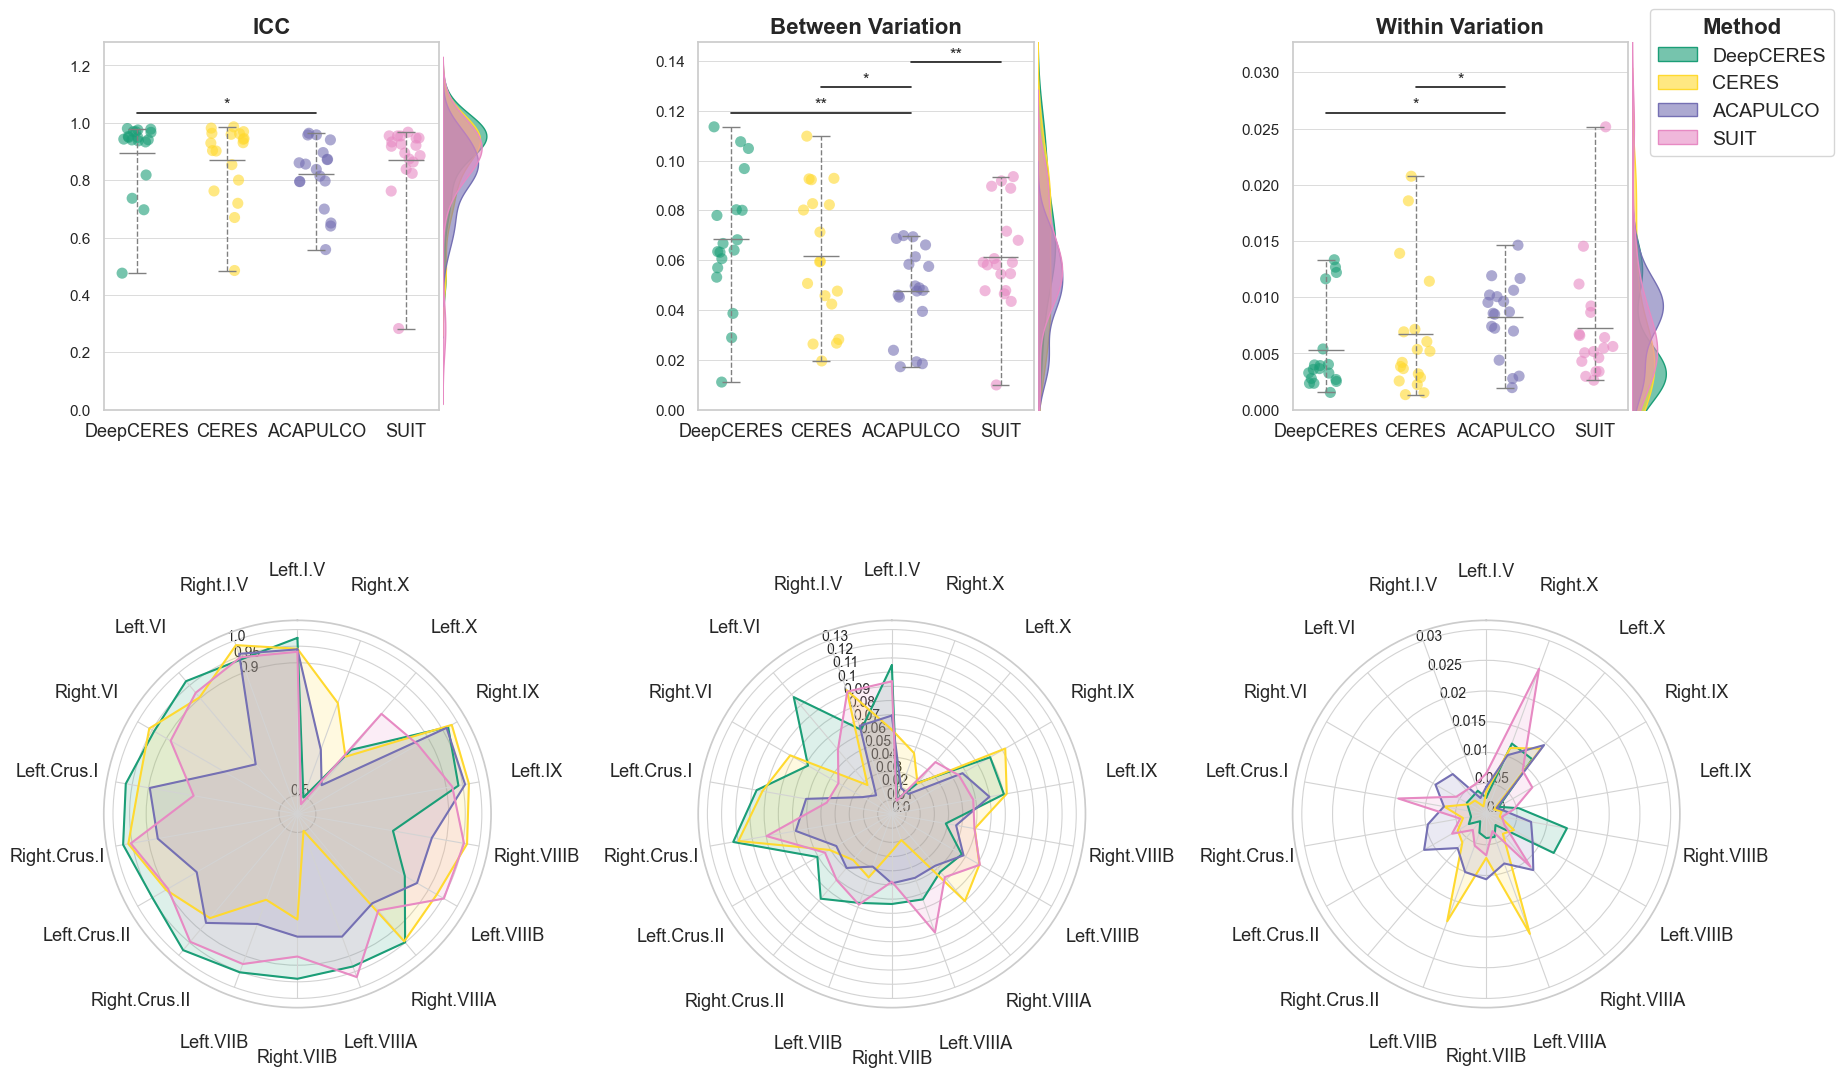

In [8]:
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 3, figure=fig, height_ratios=[0.5, 1])

regions = df_all['Lobule'].unique()
angles = np.linspace(0, 2 * np.pi, len(regions), endpoint=False).tolist()
angles += angles[:1]
radial_ticks_met = [np.array([0.5, 0.9, 0.95, 1.0]), np.arange(0.0, 0.139, 0.01), np.arange(0.0, 0.0305, 0.005)]
label_pad = [1.32, 0.172, 0.0395]

def radial_transform(x):
    return np.where(x < 0.5, x * 0.2, 0.1 + (x - 0.5) * 1.8)


for i, m in enumerate(metrics):

    # Rainplots

    # Create a nested GridSpec for scatter and density plots
    gs_inner = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0, i], width_ratios=[3.5, 0.5], wspace=0.02)
    ax_scatter = fig.add_subplot(gs_inner[0])
    ax_density = fig.add_subplot(gs_inner[1])

    # Statistical test
    p_values_dict = {}
    if m == "Between Variation":
        wide_df = df_all.pivot(index="Lobule", columns="Method", values=m)

        raw_pvals = []
        for m1, m2 in pairs:
            stat, p = ttest_rel(wide_df[m1], wide_df[m2])
            raw_pvals.append(p)

        _, pvals_corrected, _, _ = multipletests(raw_pvals, method='fdr_bh')
        p_values_dict = {(m1, m2): p_corr for (m1, m2), p_corr in zip(pairs, pvals_corrected)}
        
    else :
        res = posthoc_nemenyi_friedman(df_all, group_col='Method', y_col=m, block_col='Lobule', block_id_col='Lobule', melted=True)

        p_values_dict = {(m1, m2): res.loc[m1, m2]for m1, m2 in pairs}
    
    # Scatter Plot
    sns.stripplot(
        data=df_all, x="Method", y=m, order=methods, ax=ax_scatter,
        size=8, jitter=0.2, alpha=0.6, palette=palette, hue="Method"
    )

    # Annotate p-values
    x_positions = dict(zip(methods, range(len(methods))))
    y_max = df_all[m].max()
    h = y_max * 0.09
    y_base = y_max * 1.05
    i_star = 0

    for (m1, m2), p in p_values_dict.items():
        x1, x2 = x_positions[m1], x_positions[m2]
        y = y_base + i_star * h
        stars = get_star(p)
        if stars == "n.s.": stars = ""
        if stars:
            ax_scatter.plot([x1, x2], [y, y], lw=1.2, c='k')
            ax_scatter.text((x1 + x2) / 2, y, stars, ha='center', va='bottom', fontsize=12)
            i_star += 1

    # Density Plot
    for method in methods:
        sns.kdeplot(
            data=df_all[df_all["Method"] == method], ax=ax_density,
            color=palette[method], fill=True, alpha=0.6, label=method, y=m
        )
    
    # Add vertical line (min to max) and mean bar for each method
    for i_method, method in enumerate(methods):
        icc_values = df_all[df_all["Method"] == method][m]
        mean_icc = icc_values.mean()
        min_icc = icc_values.min()
        max_icc = icc_values.max()

        # Vertical line from min to max
        ax_scatter.vlines(x=i_method, ymin=min_icc, ymax=max_icc, color='gray', linewidth=1, zorder=4, linestyle='--')

        # Small horizontal caps at min and max
        cap_width = 0.1  # adjust as needed
        ax_scatter.hlines(y=min_icc, xmin=i_method - cap_width, xmax=i_method + cap_width, color='gray', linewidth=1, zorder=4)
        ax_scatter.hlines(y=max_icc, xmin=i_method - cap_width, xmax=i_method + cap_width, color='gray', linewidth=1, zorder=4)

        # Horizontal bar at the mean
        ax_scatter.hlines(y=mean_icc, xmin=i_method - 0.2, xmax=i_method + 0.2, color='gray', lw=1, zorder=5)
    
    # Final touches
    ax_scatter.set_ylabel("")
    ax_scatter.set_xticks(range(len(methods)))
    ax_scatter.set_xticklabels(methods)
    ax_scatter.set_ylim(0 , y_max * 1.3)
    ax_scatter.set_xlabel("")
    ax_scatter.set_title(m, weight='bold', fontsize=16)
    ax_scatter.tick_params(axis='x', labelsize=13)  
    ax_scatter.grid(axis="y", linewidth=0.6, alpha=0.8)


    ax_density.set_xlim(0.05, 4.5 / y_max)
    ax_density.set_ylim(0 , y_max * 1.3)
    ax_density.set_axis_off()



    # Radar plots

    ax_radar = fig.add_subplot(gs[1, i], polar=True)

    # Set up the radar plot
    ax_radar.xaxis.grid(False)  # Removes radial lines
    ax_radar.yaxis.grid(True, color='lightgray', linestyle='-', linewidth=0.8)
    ax_radar.set_theta_offset(np.pi / 2)  # Displace starting position
    ax_radar.set_xticklabels([])  # Clear default labels

    # Draw one line for each region
    for angle in angles[:-1]:  # Exclude the repeated last angle
        ax_radar.plot([angle, angle], [0, np.max(radial_ticks_met[i])], color='lightgray', linewidth=0.8, linestyle='-')

    # Plot values for each method
    for i_method, method in enumerate(methods):
        values = df_all[df_all["Method"] == method].set_index("Lobule").loc[regions, m].to_numpy()
        if m == "ICC":
            values = radial_transform(values)
        values_closed = list(values) + [values[0]]
        ax_radar.plot(angles, values_closed, color=colors[i_method], linewidth=1.5, label=method)
        ax_radar.fill(angles, values_closed, color=colors[i_method], alpha=0.15)

    # Customize the radial ticks
    radial_ticks_real = radial_ticks_met[i]
    if m == "ICC":
        radial_ticks_real = radial_transform(radial_ticks_real)
    ax_radar.set_yticks(radial_ticks_real)
    ax_radar.set_yticklabels([str(v) for v in radial_ticks_met[i]], fontsize=10)

    # Custom labels (regions) spaced outward from the center
    for angle, label in zip(angles[:-1], regions):
        ax_radar.text(
            angle, label_pad[i], label,
            ha='center', va='center',
            fontsize=13,
            rotation=0
        )


handles, labels = ax_density.get_legend_handles_labels()

# Place the legend outside the figure
fig.legend(
    handles,
    labels,
    title="Method",
    title_fontproperties={'weight': 'bold', 'size': 16},
    fontsize=14,
    loc='upper right',
    bbox_to_anchor=(1.03, 1)
)

# Show plot
plt.tight_layout()
#plt.savefig("big_rainplot.svg", format="svg", bbox_inches='tight')
plt.show()